In [130]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [131]:
# read grayscale image with intensity range between 0-1
def read_image(in_path):
    print(in_path)
    img = np.array(Image.open(in_path))

    # convert to floating point image with intensity [0, 1]
    if np.max(img) > 1:
        img = img.astype(np.float32) / 255.0

    # convert to grayscale
    if len(img.shape) > 2:
        img = rgb2gray(img)

    return img

In [132]:
def rescale_image(img):
  # rescale short side to standard size, then crop center
  standard = 256
  scale = standard / min(img.shape[:2])
  img = rescale(img, scale, anti_aliasing=True)
  img = img[int(img.shape[0]/2 - standard/2) : int(img.shape[0]/2 + standard/2),
            int(img.shape[1]/2 - standard/2) : int(img.shape[1]/2 + standard/2)]
  return img

### Non-Blurred

In [213]:
# Load Files
directory = '../../../Images/single class samples/Blur'

# List to hold file names
impaths = []

# Loop through directory
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        impaths.append(filename)

#### pixels_per_cell = (24, 24) 
#### cells_per_block = (3, 3)
#### orientations = 4

../../../Images/single class samples/Blur/SUV_train_orig_train_01435_resized_blurred.jpg
../../../Images/single class samples/Blur/Pickup_train_orig_train_06228_resized_blurred.jpg
../../../Images/single class samples/Blur/Sedan_train_orig_test_07439_resized_blurred.jpg
../../../Images/single class samples/Blur/Convertible_train_orig_test_03032_resized_blurred.jpg


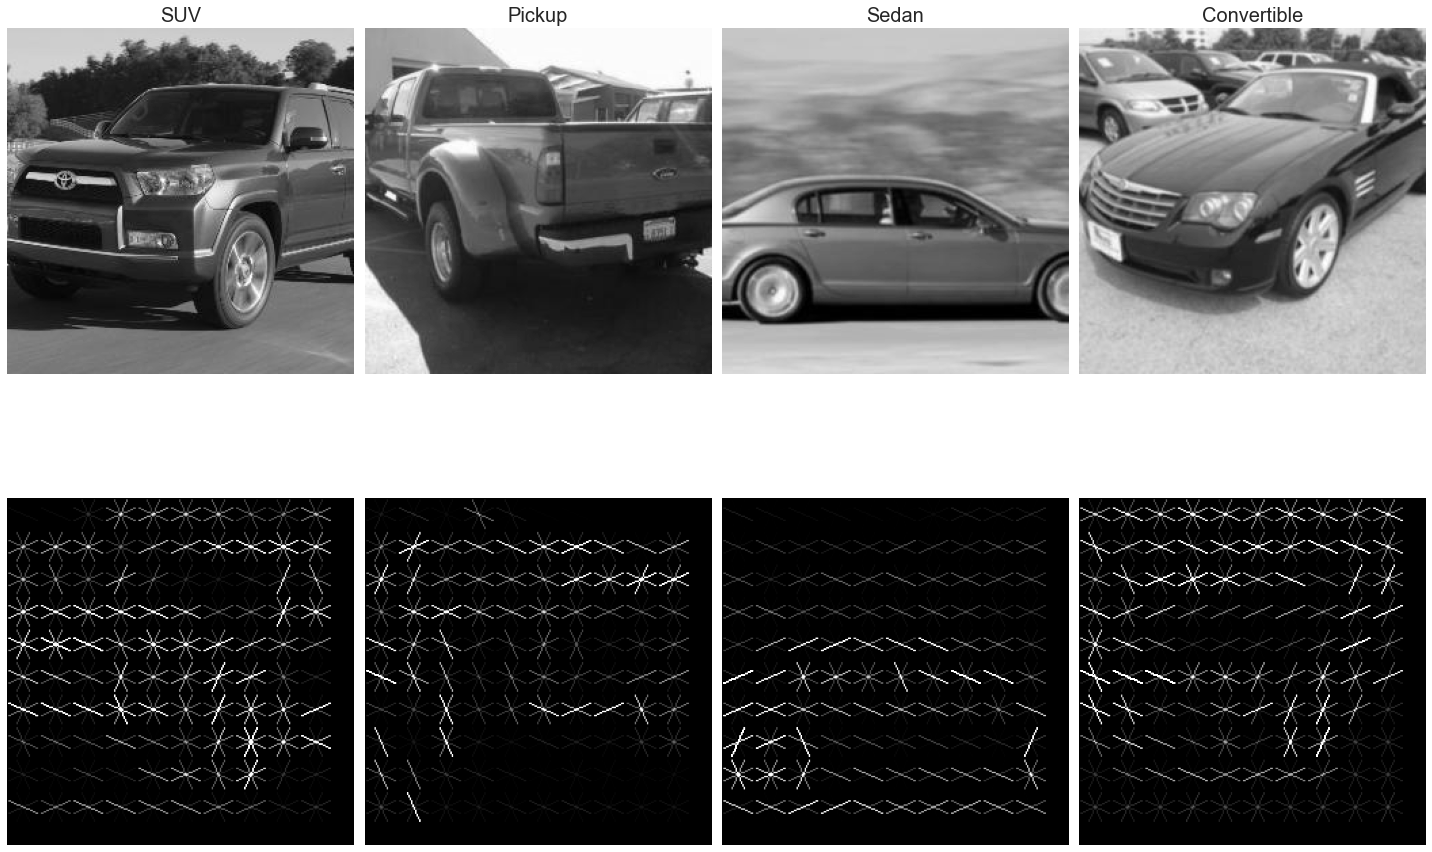

In [134]:
def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(20, 15))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (24, 24) # Adjusted as per the image size
        cells_per_block = (3, 3) # Adjusted as per the image size
        orientations = 4 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = orientations, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0], fontsize = 20)
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

#     plt.figure(figsize = (10, 5))
#     for f in features:
#         plt.plot(f, alpha = 0.25)
#     plt.title("HOG Feature Vector Plot")
#     plt.xlabel("Feature Position Index")
#     plt.ylabel("Feature Value")
#     plt.legend([car.split("_")[0] for car in impaths])
#     plt.show()

    return features


features = plot_hog_features(impaths, directory)

### All_features_train

In [135]:
# Load Files
image_list_path = '../../../Data/Features/All Features Image Paths/All_Features_Image_Paths.xlsx'
image_list = pd.read_excel(image_list_path)
image_path = image_list['Image Path HOG 24 ppc']
image_path

0       ../../../Images/train/Blurred/Sedan_train_orig...
1       ../../../Images/train/Blurred/SUV_train_orig_t...
2       ../../../Images/train/Blurred/Convertible_trai...
3       ../../../Images/train/Blurred/Pickup_train_ori...
4       ../../../Images/train/Blurred/SUV_train_orig_t...
                              ...                        
7487    ../../../Images/test/Blurred/Sedan_test_orig_t...
7488    ../../../Images/test/Blurred/SUV_test_orig_tra...
7489    ../../../Images/test/Blurred/SUV_test_orig_tes...
7490    ../../../Images/test/Blurred/Sedan_test_orig_t...
7491    ../../../Images/test/Blurred/SUV_test_orig_tes...
Name: Image Path HOG 24 ppc, Length: 7492, dtype: object

In [136]:
image_name = image_path.str.rsplit('/', n = 1).str[-1]
cars = image_name.str.split('_').str[0].tolist()

In [137]:
image_name

0         Sedan_train_orig_test_01516_resized_blurred.jpg
1          SUV_train_orig_train_00294_resized_blurred.jpg
2       Convertible_train_orig_train_04236_resized_blu...
3       Pickup_train_orig_train_03906_resized_blurred.jpg
4           SUV_train_orig_test_01344_resized_blurred.jpg
                              ...                        
7487      Sedan_test_orig_train_03968_resized_blurred.jpg
7488        SUV_test_orig_train_00034_resized_blurred.jpg
7489         SUV_test_orig_test_00579_resized_blurred.jpg
7490       Sedan_test_orig_test_07328_resized_blurred.jpg
7491         SUV_test_orig_test_02080_resized_blurred.jpg
Name: Image Path HOG 24 ppc, Length: 7492, dtype: object

In [138]:
def combine_directory_parquets(directory_path):
    '''
    Combines all parquet files in a directory into a single dataframe.
    '''
    if directory_path[-1] != '/':
        directory_path += '/'
    file_list = [f for f in os.listdir(directory_path) if f.endswith('.parquet')]
    combined_df = pd.concat([pd.read_parquet(directory_path + f) for f in file_list])
    return combined_df

In [139]:
def prepare_matrices(data):
    '''
    Takes in a dataframe and returns X and y matrices.
    '''
    # Create matrices for training
    # X is all numeric columns, y is 'Class'
    num_cols = data.select_dtypes(include=np.number).columns
    X = data[num_cols]
    y = data['Class']

    # Preprocess with standard scalar
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

In [140]:
path_to_training_data = "../../../Data/Features/All Features/train"
training_data = combine_directory_parquets(path_to_training_data)
training_data_hog = training_data[[column for column in training_data.columns if column.startswith('HOG')]]
training_data_hog['Class'] = training_data['Class']
X_train, y_train = prepare_matrices(training_data_hog)

<ipython-input-140-a66742690d70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_hog['Class'] = training_data['Class']


In [141]:
training_data_hog

HOG_24_ppc_0  HOG_24_ppc_1  HOG_24_ppc_2  HOG_24_ppc_3  HOG_24_ppc_4  \
0        0.145285      0.097244      0.197178      0.235607      0.015618   
1        0.000000      0.000000      0.000000      0.000000      0.001555   
2        0.065090      0.040544      0.230910      0.057644      0.151759   
3        0.014667      0.068248      0.147668      0.005586      0.010180   
4        0.000000      0.000000      0.000000      0.000000      0.000000   
..            ...           ...           ...           ...           ...   
370      0.106062      0.193247      0.224462      0.098806      0.133996   
371      0.024859      0.038270      0.158567      0.038280      0.090123   
372      0.090548      0.248565      0.248565      0.074245      0.080931   
373      0.130602      0.146430      0.177642      0.147891      0.142898   
374      0.000000      0.000000      0.000000      0.000000      0.000000   

     HOG_24_ppc_5  HOG_24_ppc_6  HOG_24_ppc_7  HOG_24_ppc_8  HOG_24_ppc_9  \
0        0.009979      0.025791      0.002969      0.013875      0.011411   
1        0.000000      0.001337      0.000000      0.041549      0.329805   
2        0.047050      0.230910      0.084006      0.230910      0.118567   
3        0.008797      0.171620      0.038622      0.009548      0.005871   
4        0.000000      0.000000      0.000000      0.000000      0.000000   
..            ...           ...           ...           ...           ...   
370      0.095454      0.224462      0.171191      0.224462      0.178787   
371      0.050109      0.095448      0.091144      0.122131      0.075827   
372      0.231593      0.248565      0.051372      0.051413      0.092743   
373      0.126426      0.154877      0.163687      0.250544      0.209035   
374      0.000000      0.000000      0.000000      0.000000      0.000000   

     ...  HOG_24_ppc_2295  HOG_24_ppc_2296  HOG_24_ppc_2297  HOG_24_ppc_2298  \
0    ...         0.042728         0.029283         0.053301         0.115452   
1    ...         0.001953         0.001838         0.301551         0.225546   
2    ...         0.071408         0.157386         0.439733         0.172111   
3    ...         0.012550         0.012093         0.146375         0.120334   
4    ...         0.000000         0.000000         0.000000         0.000000   
..   ...              ...              ...              ...              ...   
370  ...         0.188116         0.224245         0.161211         0.169909   
371  ...         0.005530         0.005741         0.029447         0.063609   
372  ...         0.032182         0.068687         0.163627         0.082320   
373  ...         0.187307         0.190242         0.181136         0.207621   
374  ...         0.000768         0.001124         0.021225         0.037739   

     HOG_24_ppc_2299  HOG_24_ppc_2300  HOG_24_ppc_2301  HOG_24_ppc_2302  \
0           0.028806         0.028446         0.057670         0.081800   
1           0.004867         0.029919         0.301551         0.083053   
2           0.095315         0.160153         0.439733         0.171103   
3           0.009489         0.016077         0.134045         0.126581   
4           0.000000         0.000000         0.000000         0.000000   
..               ...              ...              ...              ...   
370         0.168450         0.200348         0.141458         0.195910   
371         0.009341         0.007009         0.014027         0.124518   
372         0.056273         0.053518         0.078512         0.084608   
373         0.171375         0.174357         0.180495         0.181602   
374         0.000330         0.000927         0.004341         0.029201   

     HOG_24_ppc_2303        Class  
0           0.030000       Pickup  
1           0.020963        Sedan  
2           0.130628        Sedan  
3           0.015104        Sedan  
4           0.000000        Sedan  
..               ...          ...  
370         0.164500          SUV  
371  

In [142]:
cars_array = np.array(y_train)
df = pd.DataFrame(X_train)
df['cars'] = cars_array

# Avg
mean_features_by_cars = df.groupby('cars').mean()

print(mean_features_by_cars)

                 0         1         2         3         4         5     \
cars                                                                      
Convertible  0.025578  0.103582  0.107010  0.019257  0.028960  0.073343   
Pickup      -0.053932 -0.104627 -0.089409 -0.047177 -0.047110 -0.081168   
SUV         -0.029205 -0.010822 -0.056028 -0.023631 -0.050073 -0.000226   
Sedan        0.022293 -0.010259  0.012746  0.019681  0.032160 -0.010013   

                 6         7         8         9     ...      2294      2295  \
cars                                                 ...                       
Convertible  0.102322  0.033938  0.038456  0.050032  ... -0.001398 -0.021562   
Pickup      -0.071181 -0.030971 -0.042852 -0.073213  ...  0.039338  0.219891   
SUV         -0.041385 -0.037683 -0.034270 -0.010062  ... -0.000027  0.048301   
Sedan        0.000388  0.017478  0.016612  0.004508  ... -0.010423 -0.082974   

                 2296      2297      2298      2299      2300      2

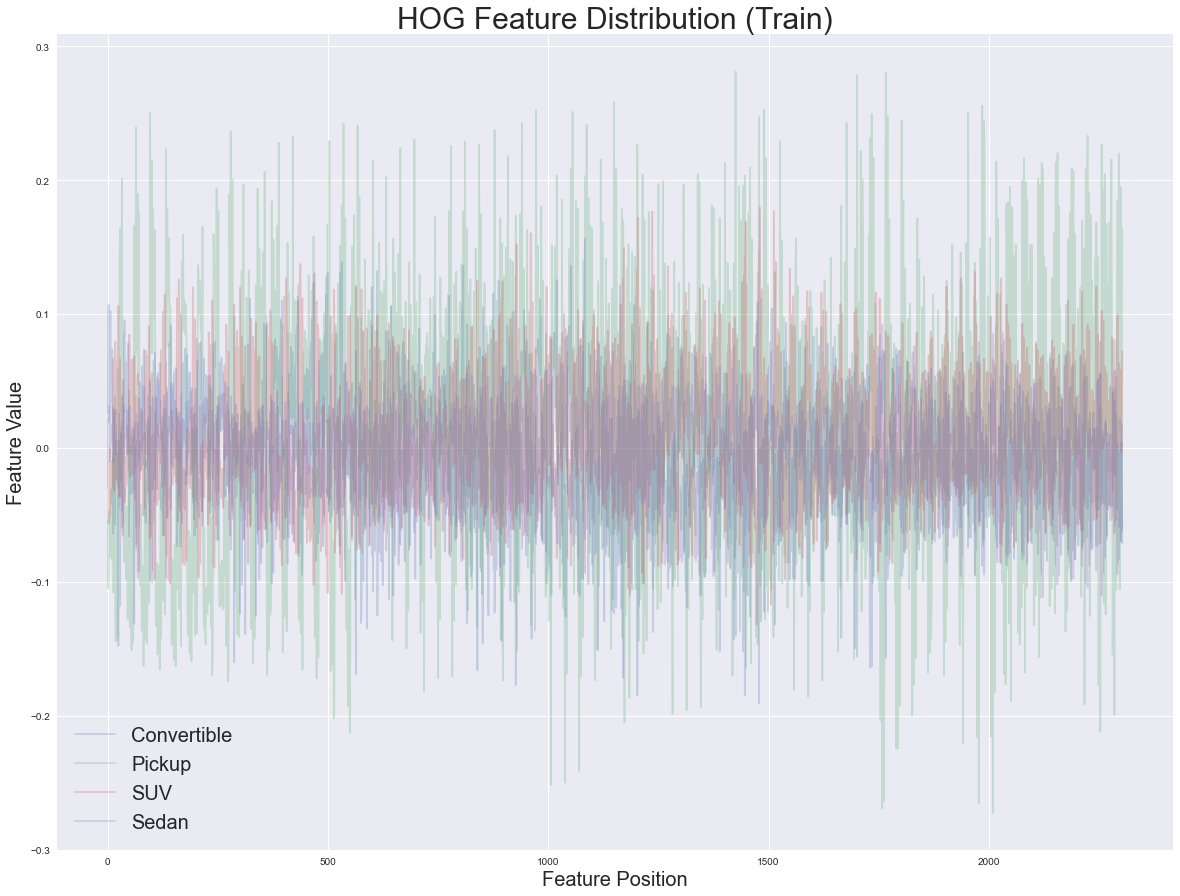

In [143]:
# Generate a histogram plot for each class
plt.figure(figsize = (20, 15))
for class_name in mean_features_by_cars.index:
    plt.plot(mean_features_by_cars.loc[class_name, :], label = class_name, alpha = 0.25)
plt.title('HOG Feature Distribution (Train)', fontsize = 30)
plt.xlabel('Feature Position', fontsize = 20)
plt.ylabel('Feature Value', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

### All_features_test

In [148]:
path_to_testing_data = "../../../Data/Features/All Features/test"
testing_data = combine_directory_parquets(path_to_testing_data)
testing_data_hog = testing_data[[column for column in testing_data.columns if column.startswith('HOG')]]
testing_data_hog['Class'] = testing_data['Class']
X_test, y_test = prepare_matrices(testing_data_hog)

<ipython-input-148-d3201166516f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data_hog['Class'] = testing_data['Class']


In [149]:
testing_data_hog

HOG_24_ppc_0  HOG_24_ppc_1  HOG_24_ppc_2  HOG_24_ppc_3  HOG_24_ppc_4  \
0       0.076599      0.256750      0.256750      0.039720      0.087858   
1       0.163188      0.071902      0.088022      0.195400      0.220379   
2       0.125096      0.178413      0.149908      0.086889      0.134275   
3       0.000000      0.000000      0.000000      0.000000      0.000000   
4       0.284005      0.284005      0.092762      0.052740      0.224117   
..           ...           ...           ...           ...           ...   
88      0.014601      0.016783      0.021337      0.014652      0.041182   
89      0.009607      0.224817      0.162674      0.004423      0.009202   
90      0.264497      0.181335      0.205816      0.150479      0.219268   
91      0.014016      0.045561      0.052689      0.008165      0.012446   
92      0.220659      0.212779      0.220659      0.207093      0.142938   

    HOG_24_ppc_5  HOG_24_ppc_6  HOG_24_ppc_7  HOG_24_ppc_8  HOG_24_ppc_9  ...  \
0       0.256750      0.256750      0.051192      0.064831      0.256750  ...   
1       0.074811      0.111288      0.176667      0.220379      0.081842  ...   
2       0.169578      0.210850      0.087850      0.114282      0.230396  ...   
3       0.000000      0.000000      0.000000      0.000000      0.000000  ...   
4       0.284005      0.061820      0.025307      0.137465      0.284005  ...   
..           ...           ...           ...           ...           ...  ...   
88      0.079919      0.027645      0.056638      0.021878      0.019908  ...   
89      0.251006      0.113454      0.005251      0.024844      0.122775  ...   
90      0.131444      0.198940      0.272598      0.191662      0.186704  ...   
91      0.031256      0.035226      0.009234      0.012428      0.038938  ...   
92      0.220659      0.213435      0.156257      0.128105      0.137245  ...   

    HOG_24_ppc_2295  HOG_24_ppc_2296  HOG_24_ppc_2297  HOG_24_ppc_2298  \
0          0.151216         0.095881         0.125134         0.124365   
1          0.221449         0.221449         0.221449         0.221449   
2          0.010648         0.009881         0.073263         0.225063   
3          0.000405         0.000000         0.000000         0.000000   
4          0.019693         0.012089         0.040606         0.316878   
..              ...              ...              ...              ...   
88         0.172576         0.153905         0.154154         0.218438   
89         0.027910         0.044048         0.037570         0.055014   
90         0.004527         0.026648         0.281678         0.240956   
91         0.183260         0.084199         0.090029         0.096490   
92         0.076135         0.087550         0.200643         0.212988   

    HOG_24_ppc_2299  HOG_24_ppc_2300  HOG_24_ppc_2301  HOG_24_ppc_2302  \
0          0.150886         0.161454         0.174606         0.128064   
1          0.221449         0.169911         0.211314         0.221449   
2          0.013915         0.010567         0.044707         0.174213   
3          0.000000         0.000000         0.000000         0.000000   
4          0.011193         0.011895         0.020754         0.293385   
..              ...              ...              ...              ...   
88         0.137059         0.148190         0.174620         0.171733   
89         0.070937         0.046653         0.049540         0.056880   
90         0.016655         0.241721         0.182964         0.050437   
91         0.076685         0.096410         0.120581         0.117411   
92         0.082108         0.109009         0.236198         0.214250   

    HOG_24_ppc_2303        Class  
0          0.127790        Sedan  
1          0.207243        Sedan  
2          0.018040  Convertible  
3          0.000000        Sedan  
4          0.013203        Sedan  
..              ...          ...  
88         0.184927        Sedan  
89         0.039783          SUV  
90         0.053775  Conv

In [150]:
cars_array = np.array(y_test)
df = pd.DataFrame(X_test)
df['cars'] = cars_array

# Avg
mean_features_by_cars = df.groupby('cars').mean()

print(mean_features_by_cars)

                 0         1         2         3         4         5     \
cars                                                                      
Convertible -0.019971 -0.035310  0.060555 -0.068492 -0.001840 -0.031765   
Pickup       0.015074 -0.110663 -0.132294  0.026867 -0.051732 -0.187121   
SUV         -0.019879  0.019482 -0.062807  0.007302 -0.028767  0.048191   
Sedan        0.019810  0.038233  0.061735  0.018640  0.039615  0.039613   

                 6         7         8         9     ...      2294      2295  \
cars                                                 ...                       
Convertible  0.075202 -0.036293  0.024696  0.017320  ...  0.020508 -0.051189   
Pickup      -0.166803 -0.047803 -0.087115 -0.176187  ... -0.057389  0.120305   
SUV         -0.008266  0.030205 -0.055457  0.025984  ... -0.044754  0.023338   
Sedan        0.024465  0.010070  0.058675  0.029324  ...  0.042865 -0.032325   

                 2296      2297      2298      2299      2300      2

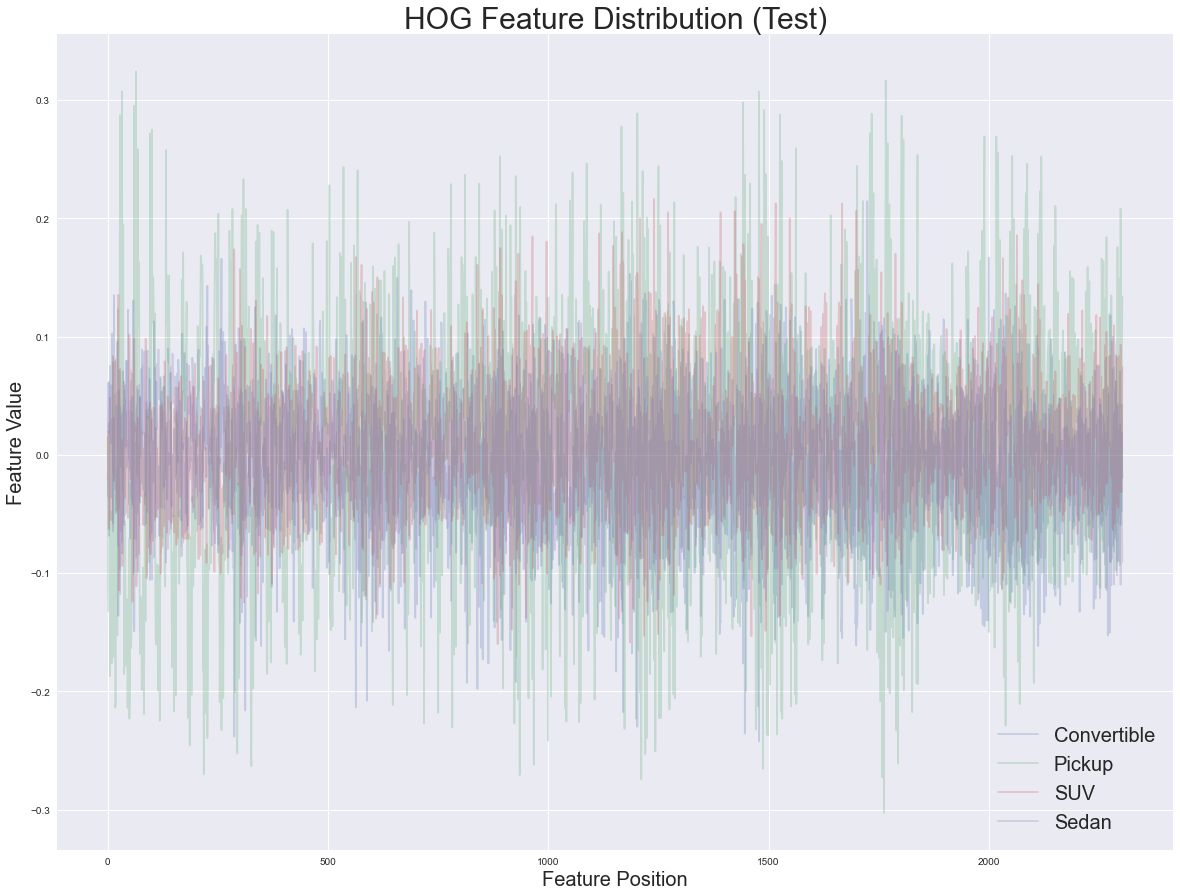

In [151]:
# Generate a histogram plot for each class
plt.figure(figsize = (20, 15))
for class_name in mean_features_by_cars.index:
    plt.plot(mean_features_by_cars.loc[class_name, :], label = class_name, alpha = 0.25)
plt.title('HOG Feature Distribution (Test)', fontsize = 30)
plt.xlabel('Feature Position', fontsize = 20)
plt.ylabel('Feature Value', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

In [ ]:
path_to_training_data = "../../../Data/Features/All Features/train"
training_data = combine_directory_parquets(path_to_training_data)
X_train, y_train = prepare_matrices(training_data)

cars_array = np.array(y_train)
df = pd.DataFrame(X_train)
df['cars'] = cars_array

# Avg
mean_features_by_cars = df.groupby('cars').mean()

print(mean_features_by_cars)

# Generate a histogram plot for each class
plt.figure(figsize = (20, 15))
for class_name in mean_features_by_cars.index:
    plt.plot(mean_features_by_cars.loc[class_name, :], label = class_name, alpha = 0.25)
plt.title('HOG Feature Distribution', fontsize = 30)
plt.xlabel('Feature Position', fontsize = 20)
plt.ylabel('Feature Value', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

#### pixels_per_cell = (24, 24) 
#### cells_per_block = (3, 3)
#### orientations = 9

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


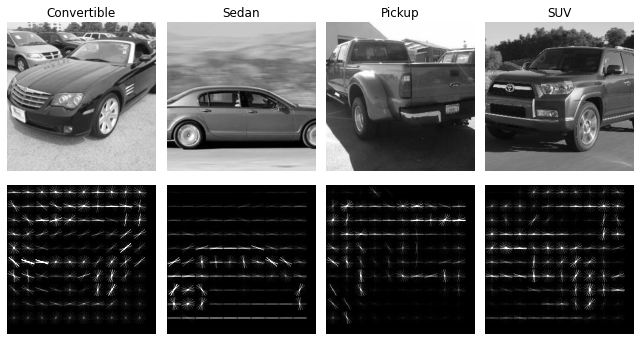

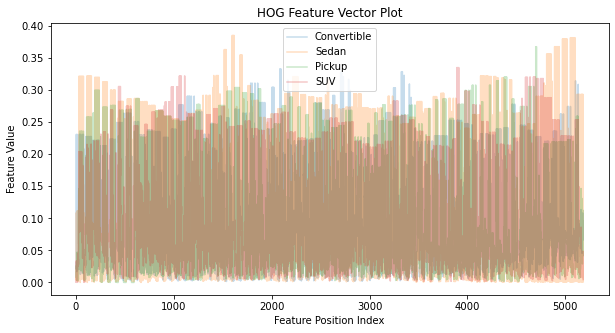

In [6]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (24, 24) # Adjusted as per the image size
        cells_per_block = (3, 3) # Adjusted as per the image size
        orientations = 9 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

#### pixels_per_cell = (24, 24) 
#### cells_per_block = (2, 2)
#### orientations = 9

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


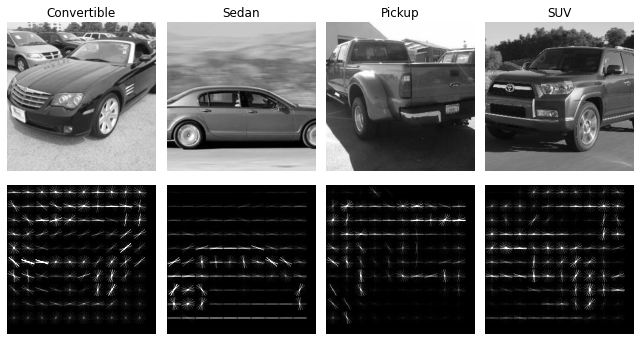

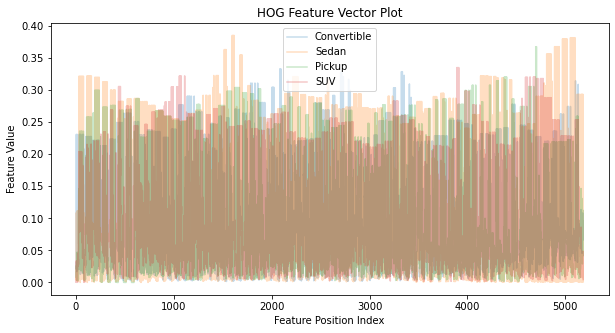

In [7]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (24, 24) # Adjusted as per the image size
        cells_per_block = (3, 3) # Adjusted as per the image size
        orientations = 9 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

#### pixels_per_cell = (24, 24) 
#### cells_per_block = (4, 4)
#### orientations = 9

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


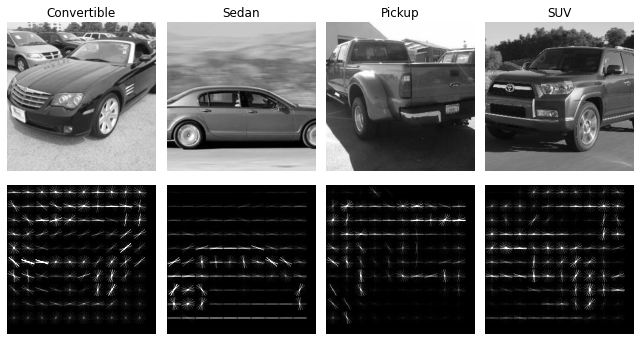

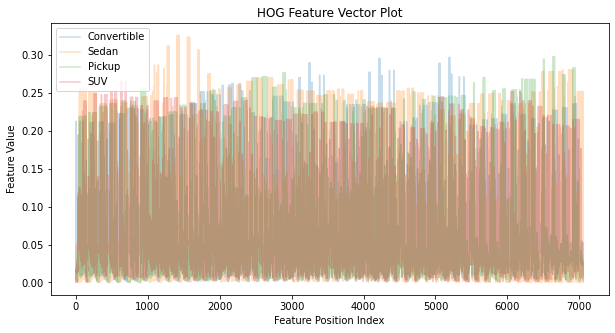

In [8]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (24, 24) # Adjusted as per the image size
        cells_per_block = (4, 4) # Adjusted as per the image size
        orientations = 9 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

#### pixels_per_cell = (16, 16) 
#### cells_per_block = (3, 3)
#### orientations = 9

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


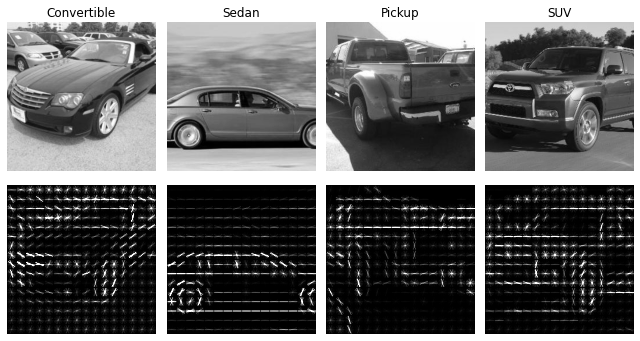

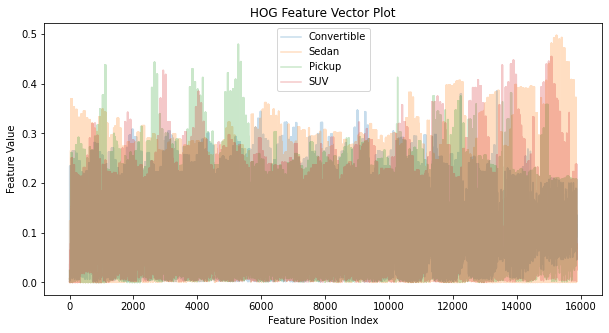

In [9]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (16, 16) # Adjusted as per the image size
        cells_per_block = (3, 3) # Adjusted as per the image size
        orientations = 9 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

#### pixels_per_cell = (16, 16) 
#### cells_per_block = (3, 3)
#### orientations = 4

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


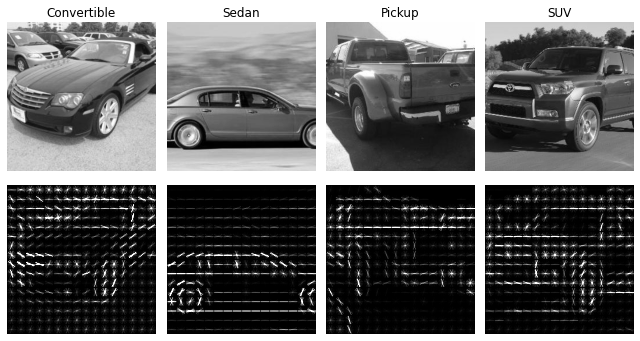

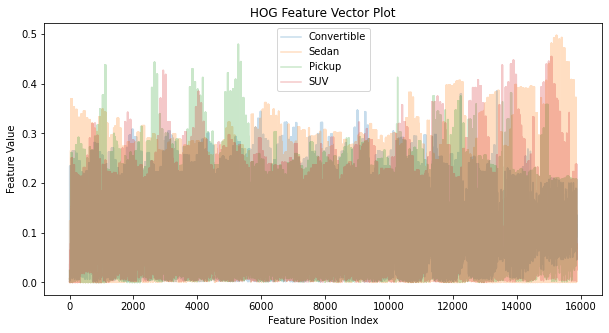

In [10]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (16, 16) # Adjusted as per the image size
        cells_per_block = (3, 3) # Adjusted as per the image size
        orientations = 4 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

#### pixels_per_cell = (16, 16) 
#### cells_per_block = (4, 4)
#### orientations = 9

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


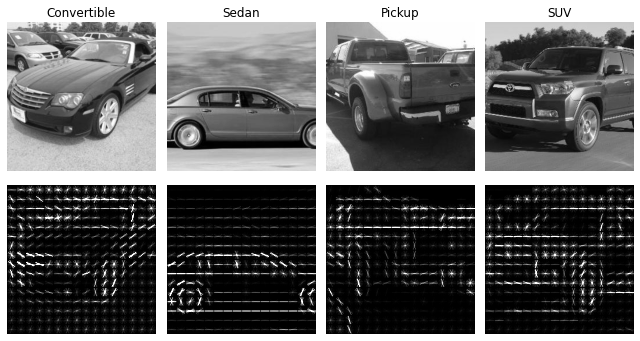

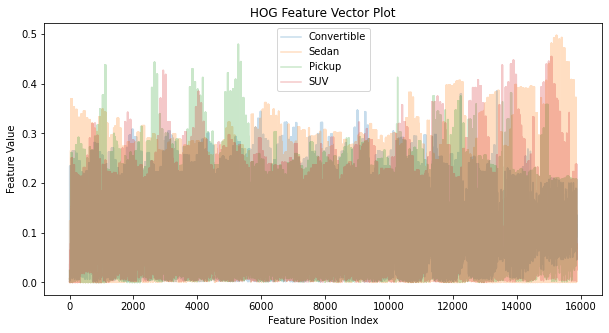

In [11]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (16, 16) # Adjusted as per the image size
        cells_per_block = (3, 3) # Adjusted as per the image size
        orientations = 4 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

#### pixels_per_cell = (8, 8) 
#### cells_per_block = (3, 3)
#### orientations = 9

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


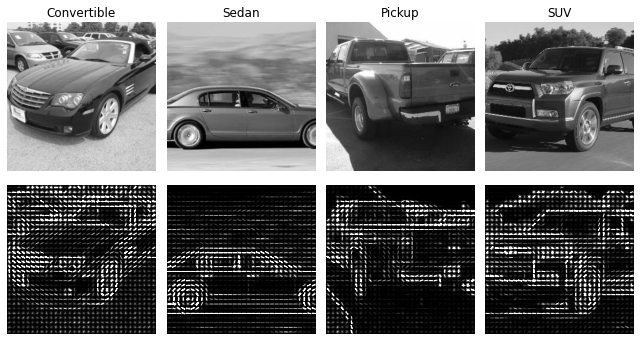

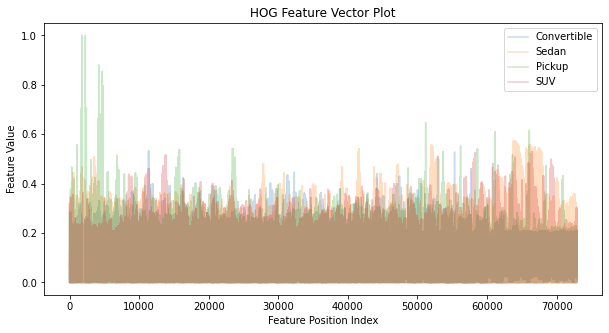

In [12]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (8, 8) # Adjusted as per the image size
        cells_per_block = (3, 3) # Adjusted as per the image size
        orientations = 9 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

#### pixels_per_cell = (8, 8) 
#### cells_per_block = (2, 2)
#### orientations = 9

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


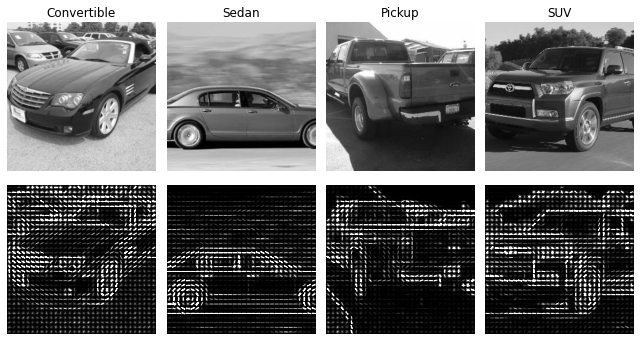

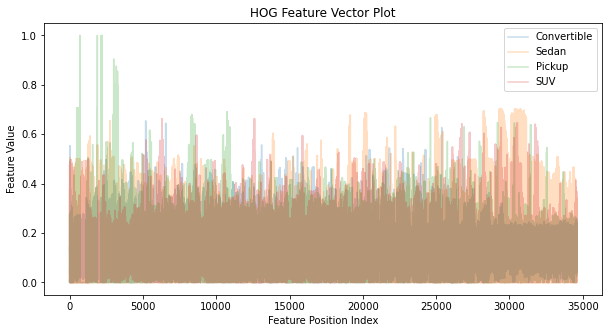

In [13]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (8, 8) # Adjusted as per the image size
        cells_per_block = (2, 2) # Adjusted as per the image size
        orientations = 9 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

#### pixels_per_cell = (8, 8) 
#### cells_per_block = (4, 4)
#### orientations = 9

../../../Images/single class samples/No Blur/Convertible_train_orig_test_03032_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Sedan_train_orig_test_07439_resized_no_blur.jpg
../../../Images/single class samples/No Blur/Pickup_train_orig_train_06228_resized_no_blur.jpg
../../../Images/single class samples/No Blur/SUV_train_orig_train_01435_resized_no_blur.jpg


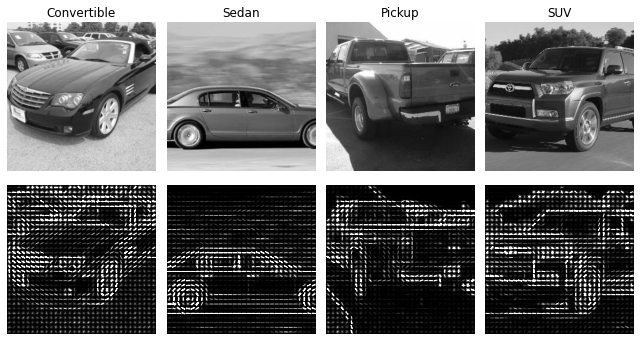

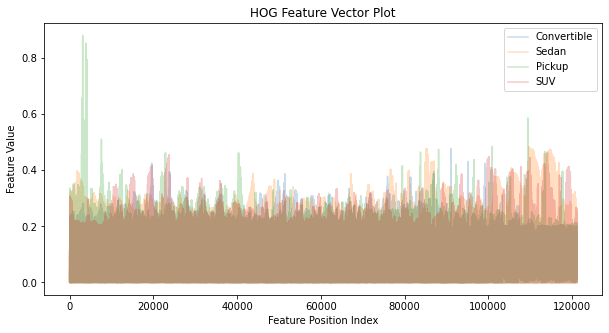

In [14]:

def plot_hog_features(impaths, directory):
    fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
    images = []
    features = []
    
    for i, impath in enumerate(impaths):
        im_processed = rescale_image(read_image(os.path.join(directory, impath)))
        images.append(im_processed)
        pixels_per_cell = (8, 8) # Adjusted as per the image size
        cells_per_block = (4, 4) # Adjusted as per the image size
        orientations = 9 # More orientations better for capturing the distinct features of the car
        f, h = hog(im_processed, orientations = 9, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, visualize = True)
        features.append(f)
        ax[0,i].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
        ax[0,i].axis('off')
        ax[0,i].set_title(impath.split("_")[0])
        ax[1,i].imshow(10*h, cmap = 'gray', vmin = 0, vmax = 0.5)
        ax[1,i].axis('off')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (10, 5))
    for f in features:
        plt.plot(f, alpha = 0.25)
    plt.title("HOG Feature Vector Plot")
    plt.xlabel("Feature Position Index")
    plt.ylabel("Feature Value")
    plt.legend([car.split("_")[0] for car in impaths])
    plt.show()

    return features


features = plot_hog_features(impaths, directory)

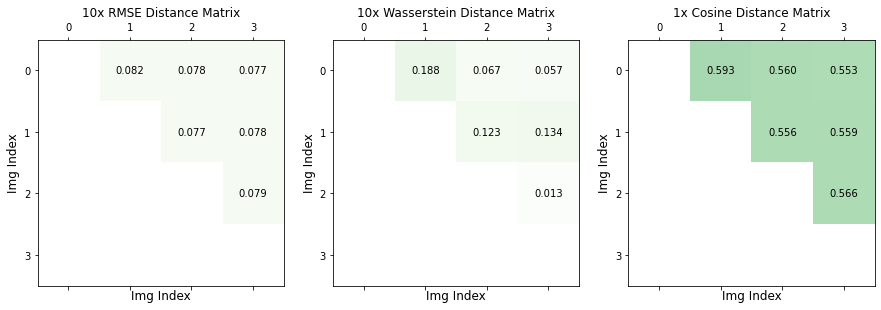

In [15]:
# compute distances
def compute_distances(features):
    N = len(features)
    features = np.array(features)
    dist_rmse = np.nan * np.ones((N, N))
    dist_wass = np.nan * np.ones((N, N))
    dist_cosn = np.nan * np.ones((N, N))
    for i in range(N):
      for j in range(i+1, N):
        dist_rmse[i, j] = mean_squared_error(features[i], features[j])
        dist_wass[i, j] = wasserstein_distance(features[i], features[j])
        dist_cosn[i, j] = cosine(features[i], features[j])
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    for fi, (label, distval) in enumerate(zip(['RMSE', 'Wasserstein', 'Cosine'], [dist_rmse, dist_wass, dist_cosn])):
      if label == 'Cosine': sf=1
      else: sf=10
    
      ax[fi].matshow(sf*distval, cmap=plt.cm.Greens, alpha=0.5, vmin=0, vmax=1)
      for i in range(distval.shape[0]):
          for j in range(distval.shape[1]):
              ax[fi].text(x=j, y=i, s=['{:.3f}'.format(sf*distval[i, j]) if not np.isnan(distval[i,j]) else ''][0], va='center', ha='center', size='medium')
      ax[fi].set_xlabel('Img Index', fontsize=12)
      ax[fi].set_ylabel('Img Index', fontsize=12)
      ax[fi].set_title('{}x {} Distance Matrix'.format(sf,label), fontsize=12)
    
    plt.show()

compute_distances(features)

# Blurred

In [16]:
# Load Files
directory_blurred = '../../../Images/single class samples/Blur'

# List to hold file names
impaths_blurred = []

# Loop through directory
for filename in os.listdir(directory_blurred):
    if os.path.isfile(os.path.join(directory_blurred, filename)):
        impaths_blurred.append(filename)

../../../Images/single class samples/Blur/SUV_train_orig_train_01435_resized_blurred.jpg
../../../Images/single class samples/Blur/Pickup_train_orig_train_06228_resized_blurred.jpg
../../../Images/single class samples/Blur/Sedan_train_orig_test_07439_resized_blurred.jpg
../../../Images/single class samples/Blur/Convertible_train_orig_test_03032_resized_blurred.jpg


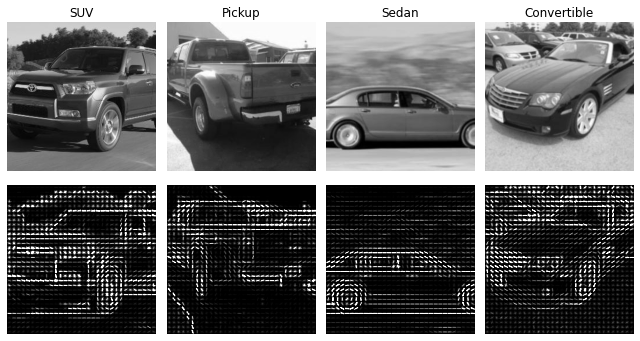

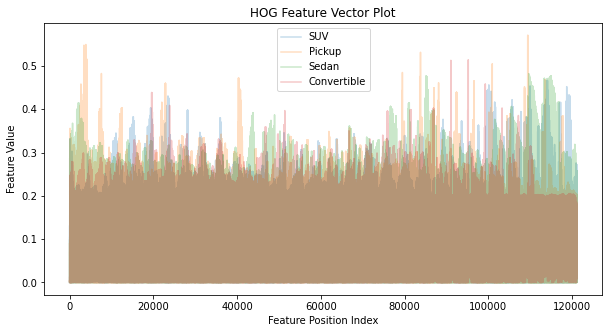

In [17]:
features_blur = plot_hog_features(impaths_blurred, directory_blurred)

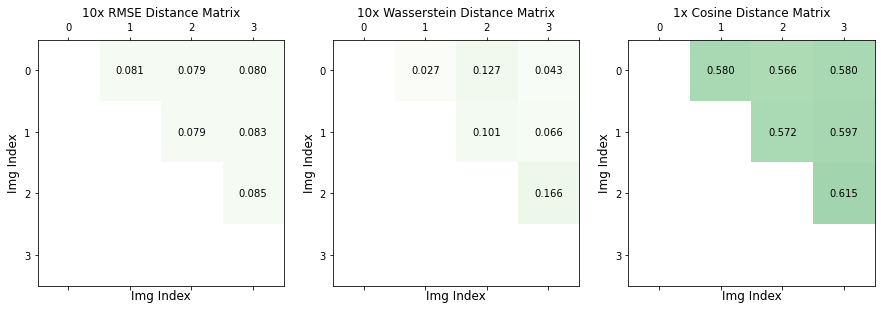

In [18]:
compute_distances(features_blur)

# Visulaizations

### Feature Distribution for HOG

In [166]:
# HOG

training_data_hog = training_data[[column for column in training_data.columns if column.startswith('HOG')]]
training_data_hog['Class'] = training_data['Class']
X_train, y_train = prepare_matrices(training_data_hog)

testing_data_hog = testing_data[[column for column in training_data.columns if column.startswith('HOG')]]
testing_data_hog['Class'] = testing_data['Class']
X_test, y_test = prepare_matrices(testing_data_hog)

X_hog = np.vstack((X_train, X_test))
y_hog = pd.concat((y_train, y_test))

cars_array = np.array(y_hog)
df = pd.DataFrame(X_hog)
df['cars'] = cars_array 

# Avg
mean_features_by_cars = df.groupby('cars').mean()

print(mean_features_by_cars)

<ipython-input-166-f34904cc599e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_hog['Class'] = training_data['Class']


                 0         1         2         3         4         5     \
cars                                                                      
Convertible  0.016623  0.076274  0.097876  0.002004  0.022904  0.052677   
Pickup      -0.039473 -0.105892 -0.098395 -0.031662 -0.048078 -0.103369   
SUV         -0.027206 -0.004325 -0.057482 -0.017000 -0.045505  0.010154   
Sedan        0.021830 -0.001227  0.021871  0.019487  0.033548 -0.000770   

                 6         7         8         9     ...      2294      2295  \
cars                                                 ...                       
Convertible  0.096989  0.020129  0.035751  0.043601  ...  0.002909 -0.027387   
Pickup      -0.091217 -0.034498 -0.052126 -0.094790  ...  0.019070  0.199025   
SUV         -0.034285 -0.023129 -0.038812 -0.002334  ... -0.009616  0.042949   
Sedan        0.004873  0.016098  0.024446  0.009130  ... -0.000498 -0.073540   

                 2296      2297      2298      2299      2300      2

<ipython-input-166-f34904cc599e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data_hog['Class'] = testing_data['Class']


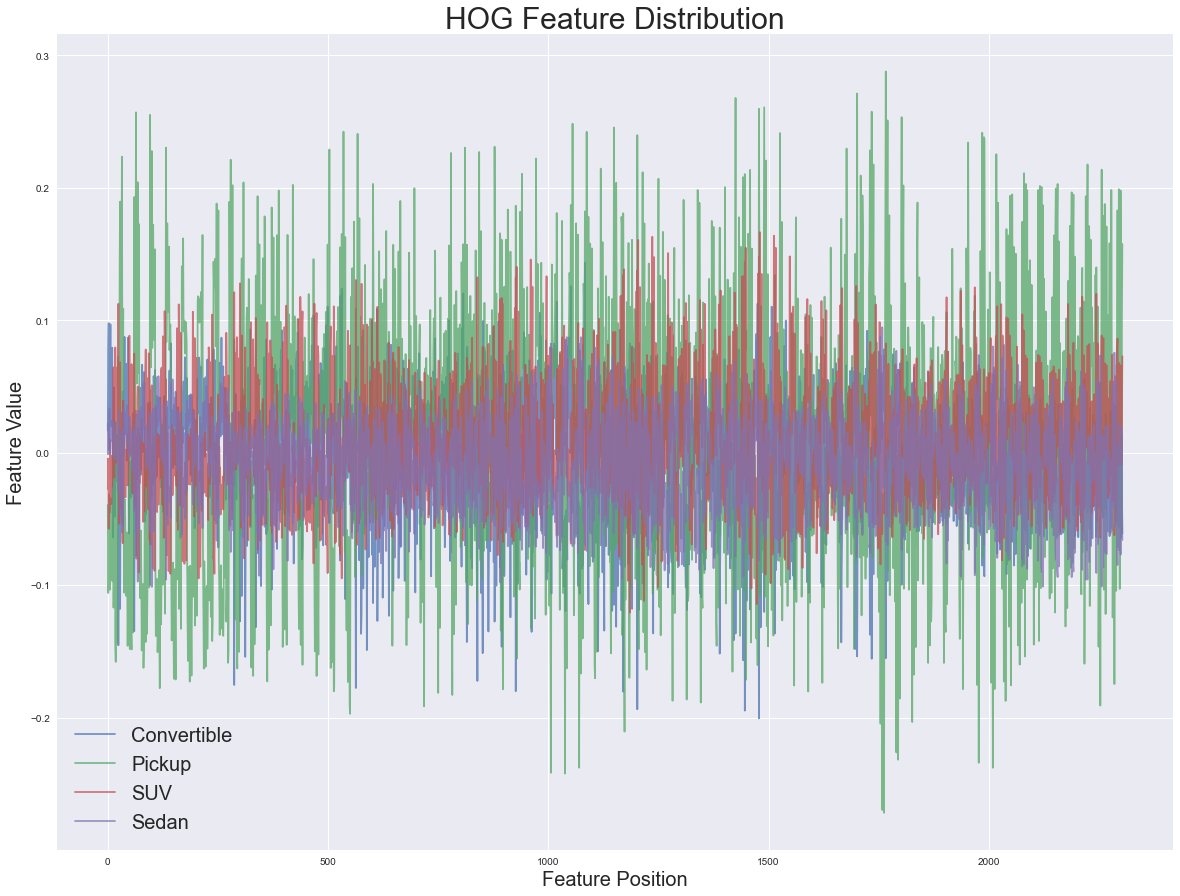

In [167]:
# Generate a histogram plot for each class
plt.figure(figsize = (20, 15))
for class_name in mean_features_by_cars.index:
    plt.plot(mean_features_by_cars.loc[class_name, :], label = class_name, alpha = 0.75)
plt.title('HOG Feature Distribution', fontsize = 30)
plt.xlabel('Feature Position', fontsize = 20)
plt.ylabel('Feature Value', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

### Feature Distribution for VGG

In [170]:
# VGG

training_data_vgg = training_data[[column for column in training_data.columns if column.startswith('VGG')]]
training_data_vgg['Class'] = training_data['Class']
X_train, y_train = prepare_matrices(training_data_vgg)

testing_data_vgg = testing_data[[column for column in training_data.columns if column.startswith('VGG')]]
testing_data_vgg['Class'] = testing_data['Class']
X_test, y_test = prepare_matrices(testing_data_vgg)

X_vgg = np.vstack((X_train, X_test))
y_vgg = pd.concat((y_train, y_test))

cars_array = np.array(y_vgg)
df = pd.DataFrame(X_vgg)
df['cars'] = cars_array 

# Avg
mean_features_by_cars = df.groupby('cars').mean()

print(mean_features_by_cars)

                  0         1         2         3         4         5    \
cars                                                                      
Convertible  0.039366 -0.139837  0.097693  0.337533  0.115638  0.069242   
Pickup      -0.062255  0.011589 -0.175163 -0.210591 -0.121815 -0.004993   
SUV          0.032118  0.038490 -0.104103 -0.106469  0.032771 -0.058658   
Sedan       -0.021122  0.034939  0.074988 -0.022479 -0.039057  0.008641   

                  6         7         8         9    ...       502       503  \
cars                                                 ...                       
Convertible  0.254880  0.171705 -0.075255  0.341173  ...  0.183757  0.073266   
Pickup      -0.244760 -0.142197 -0.104390 -0.117968  ... -0.138727  0.127960   
SUV         -0.203750 -0.070215 -0.048994 -0.107991  ... -0.112601 -0.075932   
Sedan        0.089342  0.009327  0.096894 -0.049961  ...  0.030828 -0.020293   

                  504       505       506       507       508       

<ipython-input-170-d2df4b1dc79a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_vgg['Class'] = training_data['Class']
<ipython-input-170-d2df4b1dc79a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data_vgg['Class'] = testing_data['Class']


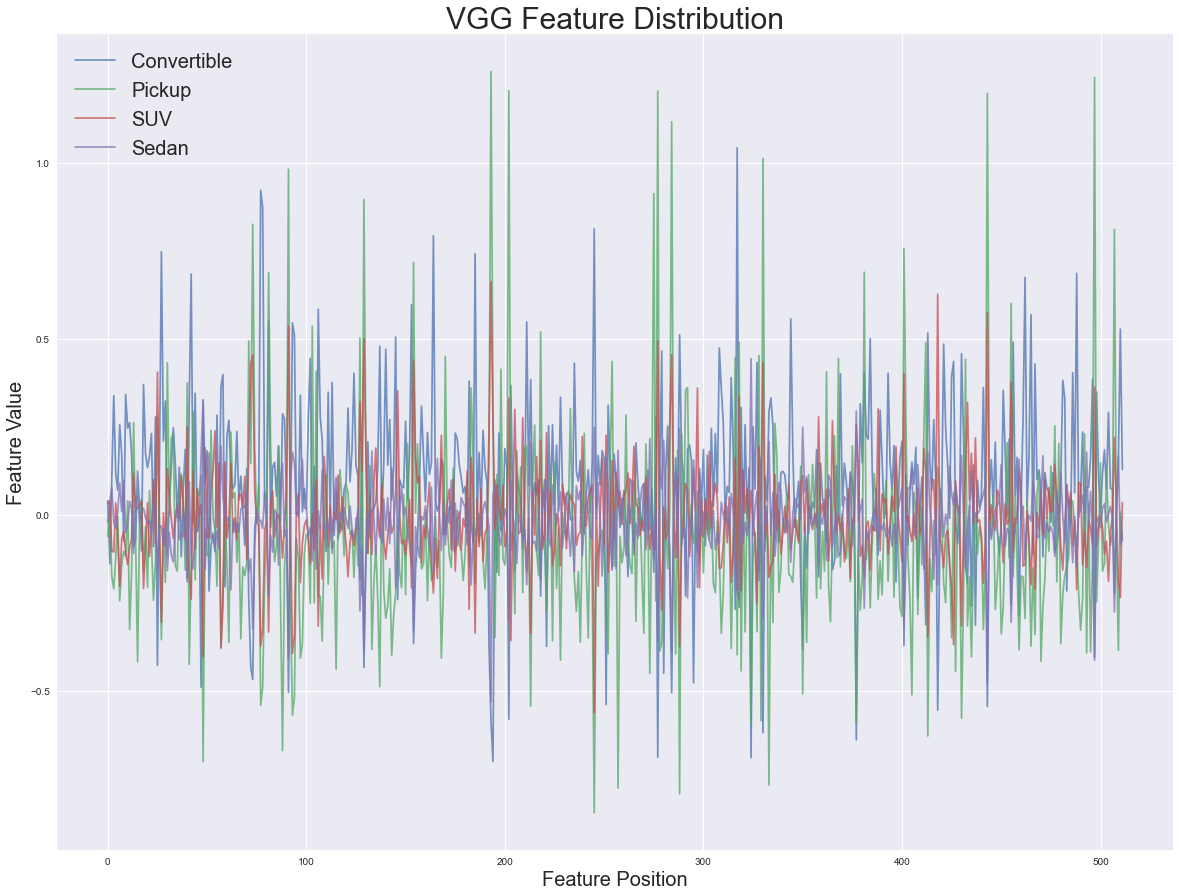

In [162]:
# Generate a histogram plot for each class
plt.figure(figsize = (20, 15))
for class_name in mean_features_by_cars.index:
    plt.plot(mean_features_by_cars.loc[class_name, :], label = class_name, alpha = 0.75)
plt.title('VGG Feature Distribution', fontsize = 30)
plt.xlabel('Feature Position', fontsize = 20)
plt.ylabel('Feature Value', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

                  0         1         2         3         4         5    \
cars                                                                      
Convertible  0.039366 -0.139837  0.097693  0.337533  0.115638  0.069242   
Pickup      -0.062255  0.011589 -0.175163 -0.210591 -0.121815 -0.004993   
SUV          0.032118  0.038490 -0.104103 -0.106469  0.032771 -0.058658   
Sedan       -0.021122  0.034939  0.074988 -0.022479 -0.039057  0.008641   

                  6         7         8         9    ...       502       503  \
cars                                                 ...                       
Convertible  0.254880  0.171705 -0.075255  0.341173  ...  0.183757  0.073266   
Pickup      -0.244760 -0.142197 -0.104390 -0.117968  ... -0.138727  0.127960   
SUV         -0.203750 -0.070215 -0.048994 -0.107991  ... -0.112601 -0.075932   
Sedan        0.089342  0.009327  0.096894 -0.049961  ...  0.030828 -0.020293   

                  504       505       506       507       508       

### Feature Distribution for ViT

In [163]:
# ViT

training_data_vit = training_data[[column for column in training_data.columns if column.startswith('ViT')]]
training_data_vit['Class'] = training_data['Class']
X_train, y_train = prepare_matrices(training_data_vit)

testing_data_vit = testing_data[[column for column in training_data.columns if column.startswith('ViT')]]
testing_data_vit['Class'] = testing_data['Class']
X_test, y_test = prepare_matrices(testing_data_vit)

X_vit = np.vstack((X_train, X_test))
y_vit = pd.concat((y_train, y_test))

cars_array = np.array(y_vit)
df = pd.DataFrame(X_vit)
df['cars'] = cars_array 

# Avg
mean_features_by_cars = df.groupby('cars').mean()

print(mean_features_by_cars)

<ipython-input-163-515559d1d07d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_vit['Class'] = training_data['Class']
<ipython-input-163-515559d1d07d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data_vit['Class'] = testing_data['Class']


                 0         1         2         3         4         5     \
cars                                                                      
Convertible  0.680302  0.079655 -1.126766 -0.333179  0.079234 -0.449679   
Pickup      -1.302582  0.306053  0.890532  0.842799 -0.277960 -0.174111   
SUV         -0.397827  0.086545  0.782828  0.029842  0.030410  0.323099   
Sedan        0.330094 -0.182117 -0.261611 -0.112013  0.024321  0.041917   

                 6         7         8         9     ...      1270      1271  \
cars                                                 ...                       
Convertible  1.074762 -0.709335  0.142487  0.382247  ...  0.122765 -0.042964   
Pickup      -0.151141  0.882882  1.349996  0.655124  ...  0.362653  0.112826   
SUV         -0.647447  0.313961  0.019084 -0.304218  ... -0.179767  0.052197   
Sedan       -0.018292 -0.139894 -0.468575 -0.162991  ... -0.042240 -0.047583   

                 1272      1273      1274      1275      1276      1

In [ ]:


# Plotting the original image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(plt.imread('/mnt/data/image.png'))
plt.title('Original Image')
plt.axis('off')

# Plotting the heatmap for Vision Transformer embeddings
plt.subplot(1, 3, 2)
plt.imshow(vit_embeddings, cmap='viridis', interpolation='nearest')
plt.title('Heatmap of ViT Embeddings')
plt.axis('off')

# Plotting the heatmap for VGG embeddings
plt.subplot(1, 3, 3)
plt.imshow(vgg_embeddings, cmap='viridis', interpolation='nearest')
plt.title('Heatmap of VGG Embeddings')
plt.axis('off')

plt.show()


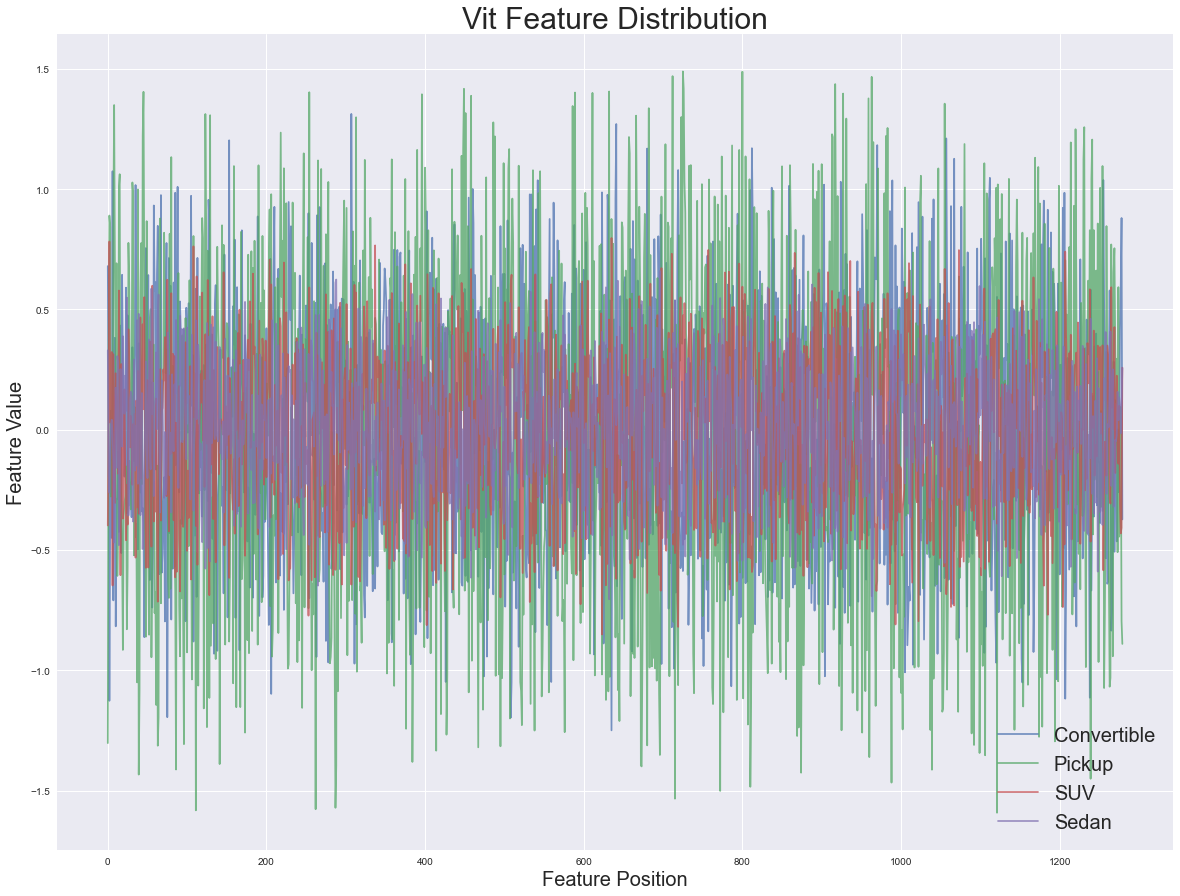

In [165]:
# Generate a histogram plot for each class
plt.figure(figsize = (20, 15))
for class_name in mean_features_by_cars.index:
    plt.plot(mean_features_by_cars.loc[class_name, :], label = class_name, alpha = 0.75)
plt.title('Vit Feature Distribution', fontsize = 30)
plt.xlabel('Feature Position', fontsize = 20)
plt.ylabel('Feature Value', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

### HeatMaps

In [234]:
# Load Files
directory = '../../../Images/single class samples/Blur'

# List to hold file names
impaths = []

# Loop through directory
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        impaths.append(filename)

In [235]:
training_data['image_path'] = training_data['image_path_blur'].str.rsplit("/", n = 1).str[-1].str.replace("resized", "resized_blurred")
data_impath = training_data[training_data['image_path'].isin(impaths)]
impaths = [im for im in data_impath['image_path'].tolist()]
impaths.sort()
data_impath.sort_values(by = 'image_path', inplace = True)

<ipython-input-235-6cdd82a6b88e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_impath.sort_values(by = 'image_path', inplace = True)


In [236]:
# ViT
training_data_vit = data_impath[[column for column in training_data.columns if column.startswith('ViT')]]
training_data_vit['Class'] = data_impath['Class']
X_vit, _ = prepare_matrices(training_data_vit)

# VGG
training_data_vit = data_impath[[column for column in training_data.columns if column.startswith('VGG')]]
training_data_vit['Class'] = data_impath['Class']
X_vgg, _ = prepare_matrices(training_data_vit)


<ipython-input-236-69f7fa2fbf19>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_vit['Class'] = data_impath['Class']
<ipython-input-236-69f7fa2fbf19>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_vit['Class'] = data_impath['Class']


../../../Images/single class samples/Blur/Convertible_train_orig_test_03032_resized_blurred.jpg
../../../Images/single class samples/Blur/Pickup_train_orig_train_06228_resized_blurred.jpg
../../../Images/single class samples/Blur/Sedan_train_orig_test_07439_resized_blurred.jpg


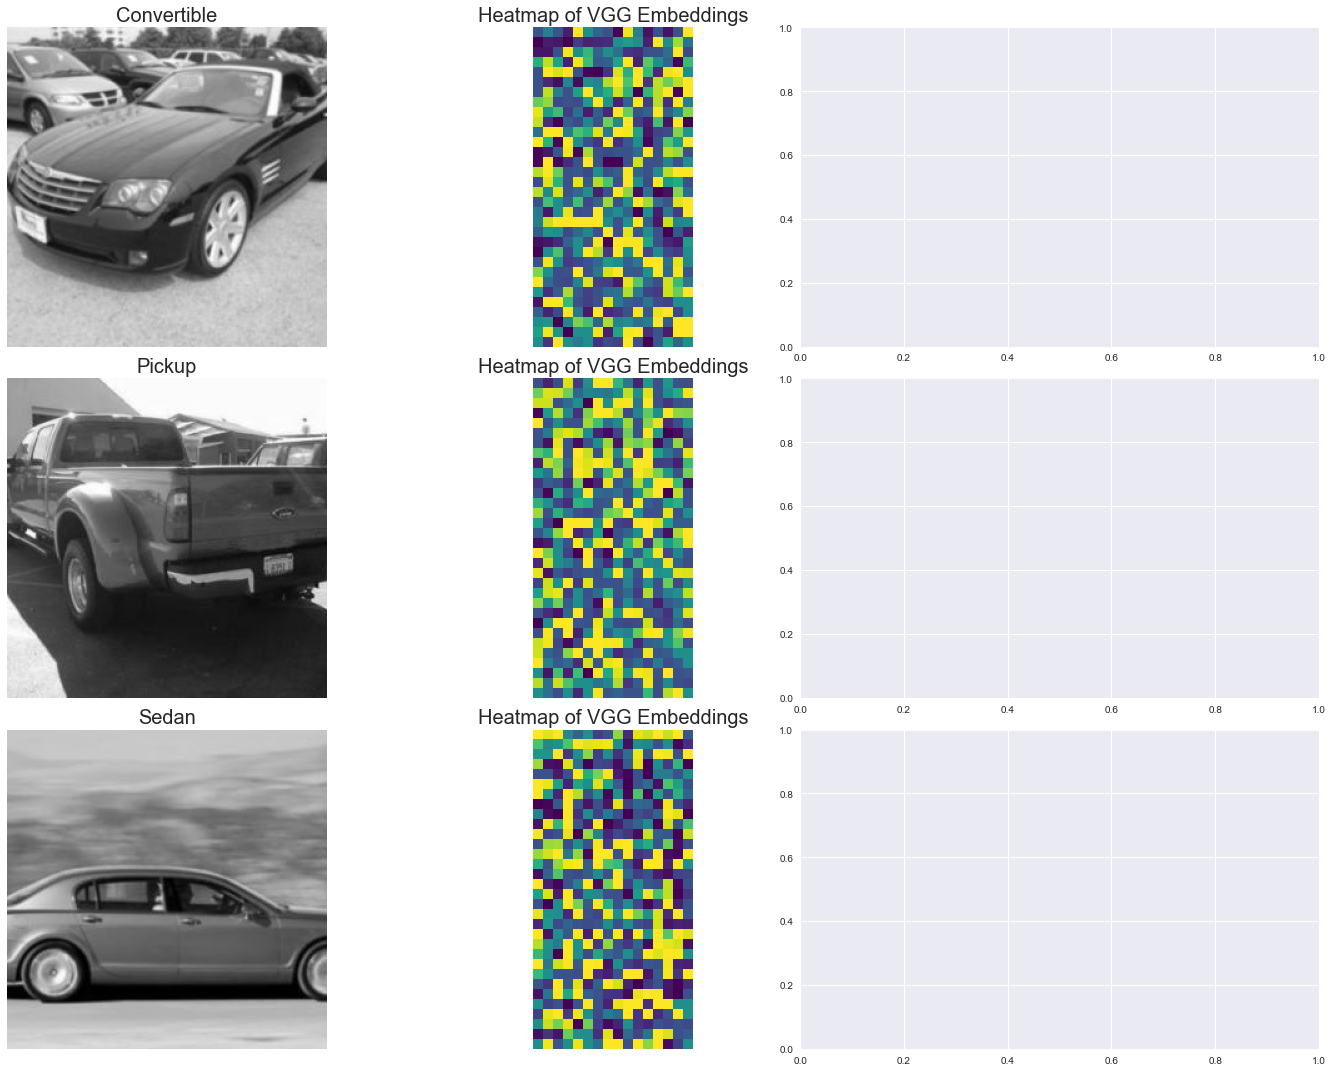

In [237]:
fig, ax = plt.subplots(nrows = len(impaths), ncols = 3, figsize = (20, 15))

for i, impath in enumerate(impaths):
    im_processed = rescale_image(read_image(os.path.join(directory, impath)))
    ax[i, 0].imshow(im_processed, cmap = 'gray', vmin = 0, vmax = 1)
    ax[i, 0].axis('off')
    ax[i, 0].set_title(impath.split("_")[0], fontsize = 20)
    ax[i, 1].imshow(X_vit[i].reshape((40, 32)), cmap='viridis', interpolation='nearest')
    ax[i, 1].set_title('Heatmap of ViT Embeddings', fontsize = 20)
    ax[i, 1].axis('off')
    ax[i, 1].imshow(X_vgg[i].reshape((32, 16)), cmap='viridis', interpolation='nearest')
    ax[i, 1].set_title('Heatmap of VGG Embeddings', fontsize = 20)
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

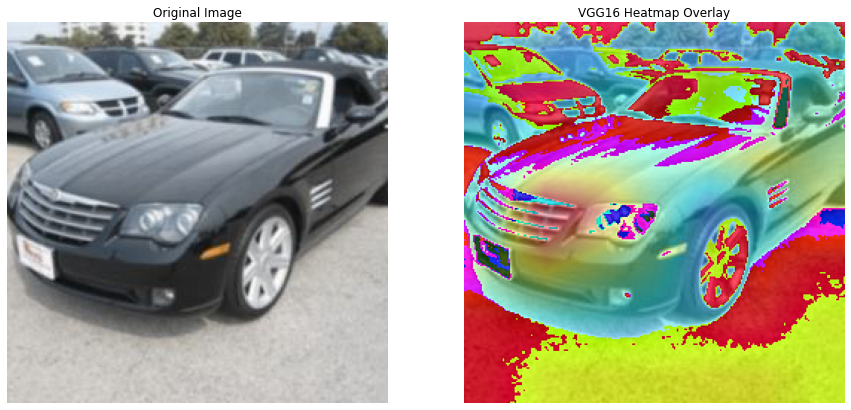

In [8]:
# VGG16

import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load VGG16 model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocess the image to convert to a suitable format for VGG16
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# generate heatmap from the feature maps
def generate_heatmap(feature_maps):
    # Take the average of the 512 channels of VGG feature maps
    heatmap = torch.mean(feature_maps, dim=1).squeeze()
    # Normalize the heatmap
    heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Overlay heatmap on the original image
def overlay_heatmap_on_image(original_img, heatmap):
    # Resize heatmap to the original image size
    heatmap = cv2.resize(heatmap, (original_img.width, original_img.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Convert RGB to BGR for OpenCV
    original_img = np.array(original_img)[:, :, ::-1]
    superimposed_img = heatmap * 0.4 + original_img
    superimposed_img = np.uint8(superimposed_img)
    # Convert back to RGB
    superimposed_img = superimposed_img[:, :, ::-1]
    return superimposed_img

def compute_vgg16_and_visualize(model, image_path):
    # Load and preprocess the image
    original_img = Image.open(image_path).convert('RGB')
    image = load_and_preprocess_image(image_path)
    
    # Get the features from one of the convolutional layers
    model_features = model.features(image)
    
    # Generate a heatmap from the feature maps
    heatmap = generate_heatmap(model_features)
    
    # Overlay the heatmap on the original image
    superimposed_img = overlay_heatmap_on_image(original_img, heatmap)
    
    # Display the original image and the heatmap overlay
    plt.figure(figsize=(15, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('VGG16 Heatmap Overlay')
    plt.axis('off')
    
    plt.show()

# Set device
device = torch.device("cpu")
model.to(device)


image_path = '../../../Images/single class samples/Blur/Convertible_train_orig_test_03032_resized_blurred.jpg'
compute_vgg16_and_visualize(model, image_path)


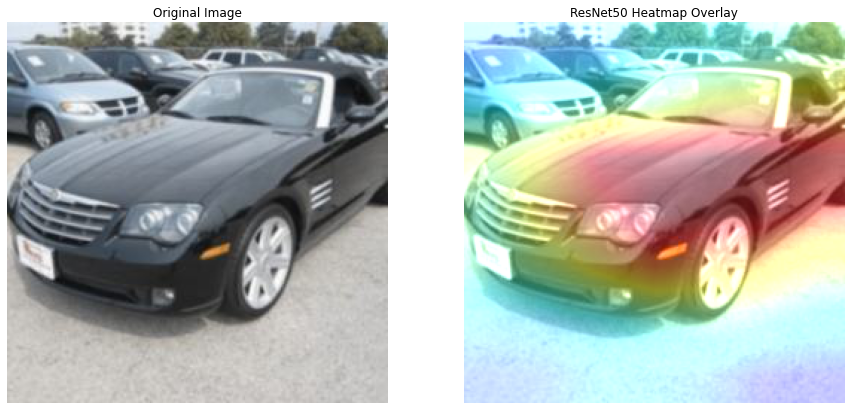

In [7]:
# Resnet50

import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define a hook to capture the output of the feature maps
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hook
model.layer4[2].register_forward_hook(get_activation('final_features'))

# Preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# Generate heatmap
def generate_heatmap(feature_maps):
    heatmap = torch.mean(feature_maps, dim=1).squeeze()
    heatmap = np.maximum(heatmap.numpy(), 0)
    heatmap /= heatmap.max()
    return heatmap

# Overlay heatmap
def overlay_heatmap_on_image(original_img, heatmap):
    heatmap = cv2.resize(heatmap, (original_img.width, original_img.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_img = np.array(original_img)[:, :, ::-1]  # Convert to BGR
    superimposed_img = heatmap * 0.4 + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    superimposed_img = superimposed_img[:, :, ::-1]  # Convert back to RGB
    return superimposed_img

# Process image and create visualization
def visualize_activation_resnet50(model, image_path):
    original_img = Image.open(image_path).convert('RGB')
    image = load_and_preprocess_image(image_path)
    
    # Forward pass
    _ = model(image)
    
    # Get feature maps
    feature_maps = activations['final_features']
    
    # Generate heatmap
    heatmap = generate_heatmap(feature_maps)
    
    # Overlay heatmap on original image
    superimposed_img = overlay_heatmap_on_image(original_img, heatmap)
    
    # Display images
    plt.figure(figsize=(15, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('ResNet50 Heatmap Overlay')
    plt.axis('off')
    
    plt.show()

# Set device
device = torch.device("cpu")
model.to(device)


image_path = '../../../Images/single class samples/Blur/Convertible_train_orig_test_03032_resized_blurred.jpg'
visualize_activation_resnet50(model, image_path)


In [10]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 15.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.7/426.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0


In [ ]:
# ViT

from transformers import ViTModel, ViTFeatureExtractor
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the ViT model and feature extractor
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)
model.to(device)

# preprocess the image and get the model's last layer features
def get_last_layer_features(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    outputs = model(**inputs)
    # Get the last hidden states
    return outputs.last_hidden_state

# fgenerate a heatmap from the last layer features
def generate_heatmap(features):
    # Remove the CLS token (first token) and calculate the norm across the hidden dimension
    patch_features = features[0, 1:, :]  # Assuming batch size of 1
    norms = torch.norm(patch_features, dim=1)
    # Reshape to (14, 14) assuming the original image size is (224, 224)
    
    return norms.view(14, 14).cpu().detach().numpy()

# overlay the heatmap on the original image
def overlay_heatmap_on_image(image_path, heatmap):
    original_img = Image.open(image_path)
    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    # Convert heatmap to color (RGB)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    # Overlay the heatmap on the original image
    superimposed_img = heatmap * 0.4 + np.array(original_img)
    return np.clip(superimposed_img, 0, 255).astype(np.uint8)

# visualize the heatmap
def visualize_heatmap(image_path):
    last_layer_features = get_last_layer_features(image_path)
    heatmap = generate_heatmap(last_layer_features)
    superimposed_img = overlay_heatmap_on_image(image_path, heatmap)

    # Plot original image and heatmap overlay
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('ViT Heatmap Overlay')
    plt.axis('off')
    plt.show()


image_path = '../../../Images/single class samples/Blur/Convertible_train_orig_test_03032_resized_blurred.jpg'
visualize_heatmap(image_path)
